### 导入库和数据

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim

In [22]:
train_set = pd.read_csv('./train_set.csv', sep='\t')
X_train, X_test, y_train, y_test = train_test_split(
    train_set['text'], 
    train_set['label'], 
    random_state=42
)

In [23]:
sequence_length = 3000
embedding_dimension = 256
num_words = 8000
model_save_path = "./textcnn.h5"

In [24]:
X_train = np.array([np.array([int(y) for y in x.split()]) for x in tqdm(X_train.to_list())])
X_test = np.array([np.array([int(y) for y in x.split()]) for x in tqdm(X_test.to_list())])

  0%|          | 0/150000 [00:00<?, ?it/s]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


  0%|          | 0/50000 [00:00<?, ?it/s]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [25]:
X_train, X_test = pad_sequences(X_train, maxlen=sequence_length), pad_sequences(X_test,maxlen=sequence_length)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=14)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=14)

### 构建TextCNN网络

In [15]:
# 构造分类器
filter_sizes = [3, 4, 5]


def convolution():
    # 定义输入层，制定输入数据的形状
    inn = layers.Input(shape=(sequence_length, embedding_dimension, 1))
    cnns = []
    for size in filter_sizes:
        conv = layers.Conv2D(
            filters=64,  # 卷积层神经元（卷积核）数目
            kernel_size=(size, embedding_dimension),  # 卷积核大小
            strides=1,  # 设置步长
            padding='valid',  # padding策略（vaild 或 same） 
            activation='relu')(inn)  # 激活函数

        pool = layers.MaxPool2D(pool_size=(sequence_length - size + 1, 1),
                                padding='valid')(conv)
        cnns.append(pool)
    outt = layers.concatenate(cnns)

    model = keras.Model(inputs=inn, outputs=outt)
    return model


def cnn_mulfilter():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_words,
                         output_dim=embedding_dimension,
                         input_length=sequence_length),
        layers.Reshape((sequence_length, embedding_dimension, 1)),
        convolution(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(14, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=[tfa.metrics.F1Score(num_classes=14, average='macro')])
    return model


model = cnn_mulfilter()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3000, 256)         2048000   
_________________________________________________________________
reshape (Reshape)            (None, 3000, 256, 1)      0         
_________________________________________________________________
model (Functional)           (None, 1, 1, 192)         196800    
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                12352     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                9

### 模型训练

In [7]:
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Epoch 1/5
2110/2110 [==============================] - ETA: 0s - loss: 0.3793 - f1_score: 0.8475

C:\Users\陈继延\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


2110/2110 [==============================] - 1742s 542ms/step - loss: 0.3793 - f1_score: 0.8475 - val_loss: 0.2116 - val_f1_score: 0.9302
Epoch 2/5
2110/2110 [==============================] - 917s 435ms/step - loss: 0.1781 - f1_score: 0.9351 - val_loss: 0.1977 - val_f1_score: 0.9343
Epoch 3/5
2110/2110 [==============================] - 917s 434ms/step - loss: 0.1291 - f1_score: 0.9523 - val_loss: 0.2155 - val_f1_score: 0.9312
Epoch 4/5
2110/2110 [==============================] - 915s 434ms/step - loss: 0.0961 - f1_score: 0.9641 - val_loss: 0.2024 - val_f1_score: 0.9363
Epoch 5/5
2110/2110 [==============================] - 916s 434ms/step - loss: 0.0724 - f1_score: 0.9716 - val_loss: 0.2221 - val_f1_score: 0.9367


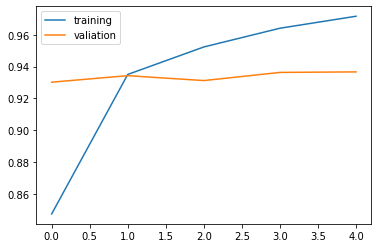

In [8]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()

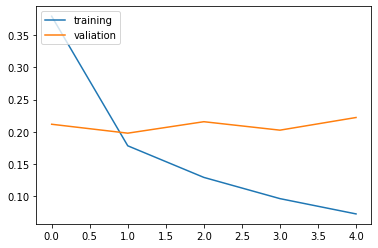

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()

In [10]:
result = model.evaluate(X_test, y_test)
print("loss=%.3f,accuracy=%.3f" %(result[0],result[1]))

C:\Users\陈继延\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


1563/1563 [==============================] - 133s 84ms/step - loss: 0.2154 - f1_score: 0.9353
loss=0.215,accuracy=0.935


In [11]:
# 保存模型
model.save(model_save_path)

### 结果测试

In [ ]:
# 加载模型
from tensorflow.keras.models import load_model
model = load_model(model_save_path)

In [12]:
y_pred = model.predict(X_test)

In [18]:
from sklearn.metrics import f1_score, confusion_matrix
from seaborn import heatmap

In [25]:
result_matrix = pd.DataFrame(confusion_matrix([np.argmax(x) for x in y_test], [np.argmax(x) for x in y_pred]))

In [16]:
f1_score([np.argmax(x) for x in y_test], [np.argmax(x) for x in y_pred], average='macro')

0.9352764380268035

<AxesSubplot:>

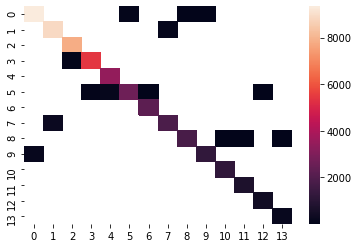

In [35]:
heatmap(result_matrix.apply(lambda x:x.nlargest(2)))

In [36]:
result_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,9340,139,11,43,102,78,13,18,20,26,0,3,3,1
1,106,8893,3,7,70,1,3,131,3,0,1,0,1,0
2,14,5,7830,42,40,9,4,0,1,0,0,1,3,0
3,75,15,24,5402,29,25,3,5,10,4,0,7,0,1
4,58,83,9,19,3449,54,6,7,1,0,0,6,3,0
5,112,19,5,51,143,2635,26,22,0,1,0,3,8,0
6,39,12,5,12,50,59,2241,4,6,0,0,4,2,1
7,27,269,0,4,19,13,3,1857,4,0,0,0,4,0
8,67,35,7,35,14,11,12,7,1778,0,4,8,1,4
9,157,5,3,15,4,2,5,3,0,1237,0,1,1,0


### 使用官方提供的预训练词向量

In [21]:
# 构建word-vector字典
with open(path, encoding='utf-8') as f:
    lines = f.readlines()
    items = lines[0].split()
    count, dim = int(items[0]), int(items[1])

embeddings = np.zeros((8000, dim))
for index, line in tqdm(enumerate(lines[1:])):
    values = line.split()
    word = int(values[0])
    vector = np.array(values[1:], dtype='float64')
    embeddings[word] = vector

0it [00:00, ?it/s]

In [22]:
# 构造分类器
filter_sizes = [3, 4, 5]


def convolution():
    # 定义输入层，制定输入数据的形状
    inn = layers.Input(shape=(sequence_length, dim, 1))
    cnns = []
    for size in filter_sizes:
        conv = layers.Conv2D(
            filters=64,  # 卷积层神经元（卷积核）数目
            kernel_size=(size, dim),  # 卷积核大小
            strides=1,  # 设置步长
            padding='valid',  # padding策略（vaild 或 same） 
            activation='relu')(inn)  # 激活函数

        pool = layers.MaxPool2D(pool_size=(sequence_length - size + 1, 1),
                                padding='valid')(conv)
        cnns.append(pool)
    outt = layers.concatenate(cnns)

    model = keras.Model(inputs=inn, outputs=outt)
    return model

def cnn_mulfilter():
    model = keras.Sequential([
        layers.Embedding(input_dim=len(embeddings),
                         output_dim=dim,
                         weights=[embeddings],
                         input_length=sequence_length,
                         trainable=False),
        layers.Reshape((sequence_length, dim, 1)),
        convolution(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(14, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[tfa.metrics.F1Score(num_classes=14, average='macro')])
    return model


model = cnn_mulfilter()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 3000, 100)         800000    
_________________________________________________________________
reshape_4 (Reshape)          (None, 3000, 100, 1)      0         
_________________________________________________________________
model_4 (Functional)         (None, 1, 1, 192)         76992     
_________________________________________________________________
flatten_4 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                12352     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 14)               

In [23]:
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Epoch 1/5
2110/2110 [==============================] - ETA: 0s - loss: 0.4899 - f1_score: 0.7710

C:\Users\陈继延\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


2110/2110 [==============================] - 405s 187ms/step - loss: 0.4899 - f1_score: 0.7710 - val_loss: 0.2463 - val_f1_score: 0.9019
Epoch 2/5
2110/2110 [==============================] - 402s 190ms/step - loss: 0.2312 - f1_score: 0.9064 - val_loss: 0.2082 - val_f1_score: 0.9245
Epoch 3/5
2110/2110 [==============================] - 399s 189ms/step - loss: 0.1867 - f1_score: 0.9261 - val_loss: 0.2002 - val_f1_score: 0.9273
Epoch 4/5
2110/2110 [==============================] - 399s 189ms/step - loss: 0.1593 - f1_score: 0.9376 - val_loss: 0.2060 - val_f1_score: 0.9316
Epoch 5/5
2110/2110 [==============================] - 398s 189ms/step - loss: 0.1392 - f1_score: 0.9459 - val_loss: 0.2104 - val_f1_score: 0.9302


In [25]:
y_pred = model.predict(X_test)

In [26]:
from sklearn.metrics import f1_score, confusion_matrix
from seaborn import heatmap
result_matrix = pd.DataFrame(confusion_matrix([np.argmax(x) for x in y_test], [np.argmax(x) for x in y_pred]))
f1_score([np.argmax(x) for x in y_test], [np.argmax(x) for x in y_pred], average='macro')

0.9263408039603096

In [36]:
from seaborn import heatmap
heatmap(result_matrix.apply(lambda x:x.nlargest(2)))

NameError: name 'result_matrix' is not defined

### 使用自己训练的词向量

In [31]:
w2v = gensim.models.Word2Vec.load('./w2c_256')
embeddings = np.zeros((8000, 256))
indexs = w2v.wv.index_to_key
vecotrs = w2v.wv.vectors
for index, vector in zip(indexs, vecotrs):
    embeddings[int(index)] = vector

In [33]:
# 构造分类器
filter_sizes = [3, 4, 5]


def convolution():
    # 定义输入层，制定输入数据的形状
    inn = layers.Input(shape=(sequence_length, embedding_dimension, 1))
    cnns = []
    for size in filter_sizes:
        conv = layers.Conv2D(
            filters=64,  # 卷积层神经元（卷积核）数目
            kernel_size=(size, embedding_dimension),  # 卷积核大小
            strides=1,  # 设置步长
            padding='valid',  # padding策略（vaild 或 same） 
            activation='relu')(inn)  # 激活函数

        pool = layers.MaxPool2D(pool_size=(sequence_length - size + 1, 1),
                                padding='valid')(conv)
        cnns.append(pool)
    outt = layers.concatenate(cnns)

    model = keras.Model(inputs=inn, outputs=outt)
    return model

def cnn_mulfilter():
    model = keras.Sequential([
        layers.Embedding(input_dim=len(embeddings),
                         output_dim=embedding_dimension,
                         weights=[embeddings],
                         input_length=sequence_length,
                         trainable=False),
        layers.Reshape((sequence_length, embedding_dimension, 1)),
        convolution(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(14, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[tfa.metrics.F1Score(num_classes=14, average='macro')])
    return model


model = cnn_mulfilter()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3000, 256)         2048000   
_________________________________________________________________
reshape_1 (Reshape)          (None, 3000, 256, 1)      0         
_________________________________________________________________
model_1 (Functional)         (None, 1, 1, 192)         196800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 14)               

In [34]:
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Epoch 1/5
2110/2110 [==============================] - ETA: 0s - loss: 0.4296 - f1_score: 0.8167

C:\Users\陈继延\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


2110/2110 [==============================] - 690s 323ms/step - loss: 0.4296 - f1_score: 0.8167 - val_loss: 0.2683 - val_f1_score: 0.9019
Epoch 2/5
2110/2110 [==============================] - 675s 320ms/step - loss: 0.2881 - f1_score: 0.8846 - val_loss: 0.2493 - val_f1_score: 0.9117
Epoch 3/5
2110/2110 [==============================] - 674s 320ms/step - loss: 0.2461 - f1_score: 0.9022 - val_loss: 0.2500 - val_f1_score: 0.9226
Epoch 4/5
2110/2110 [==============================] - 673s 319ms/step - loss: 0.2167 - f1_score: 0.9156 - val_loss: 0.2315 - val_f1_score: 0.9272
Epoch 5/5
2110/2110 [==============================] - 673s 319ms/step - loss: 0.1969 - f1_score: 0.9227 - val_loss: 0.2299 - val_f1_score: 0.9264


In [37]:
y_pred = model.predict(X_test)

In [38]:
from sklearn.metrics import f1_score, confusion_matrix
from seaborn import heatmap
result_matrix = pd.DataFrame(confusion_matrix([np.argmax(x) for x in y_test], [np.argmax(x) for x in y_pred]))
f1_score([np.argmax(x) for x in y_test], [np.argmax(x) for x in y_pred], average='macro')

0.927503472961493

<AxesSubplot:>

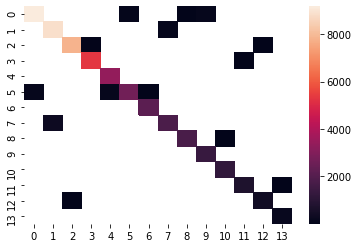

In [39]:
from seaborn import heatmap
heatmap(result_matrix.apply(lambda x:x.nlargest(2)))